<a href="https://colab.research.google.com/github/bwr02/ECE180-Final/blob/GPT-Residual/ECE180_Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 180 Final Project
This is the official notebook that we will present. Please keep it nice and clean.

## Task
- 30 kinds of balls

## Model Architecture
- TBD

## Group members
- Barry Wang
- Ben Richardson
- Allan Garcia
- Kevin Fan
- Thomas Duan
- Eshan Joshi

In [1]:
# Generic Data Handling
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# PyTorch Basic Needs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Add other stuff as we go
import random

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


#Data Importing and Preprocessing
Import the dataset and group into training, validation, and testing groups. We may need to do cross validation.

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='~/Downloads/balls_image_classification/train', transform=transform)
val_dataset = datasets.ImageFolder(root='~/Downloads/balls_image_classification/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='~/Downloads/balls_image_classification/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

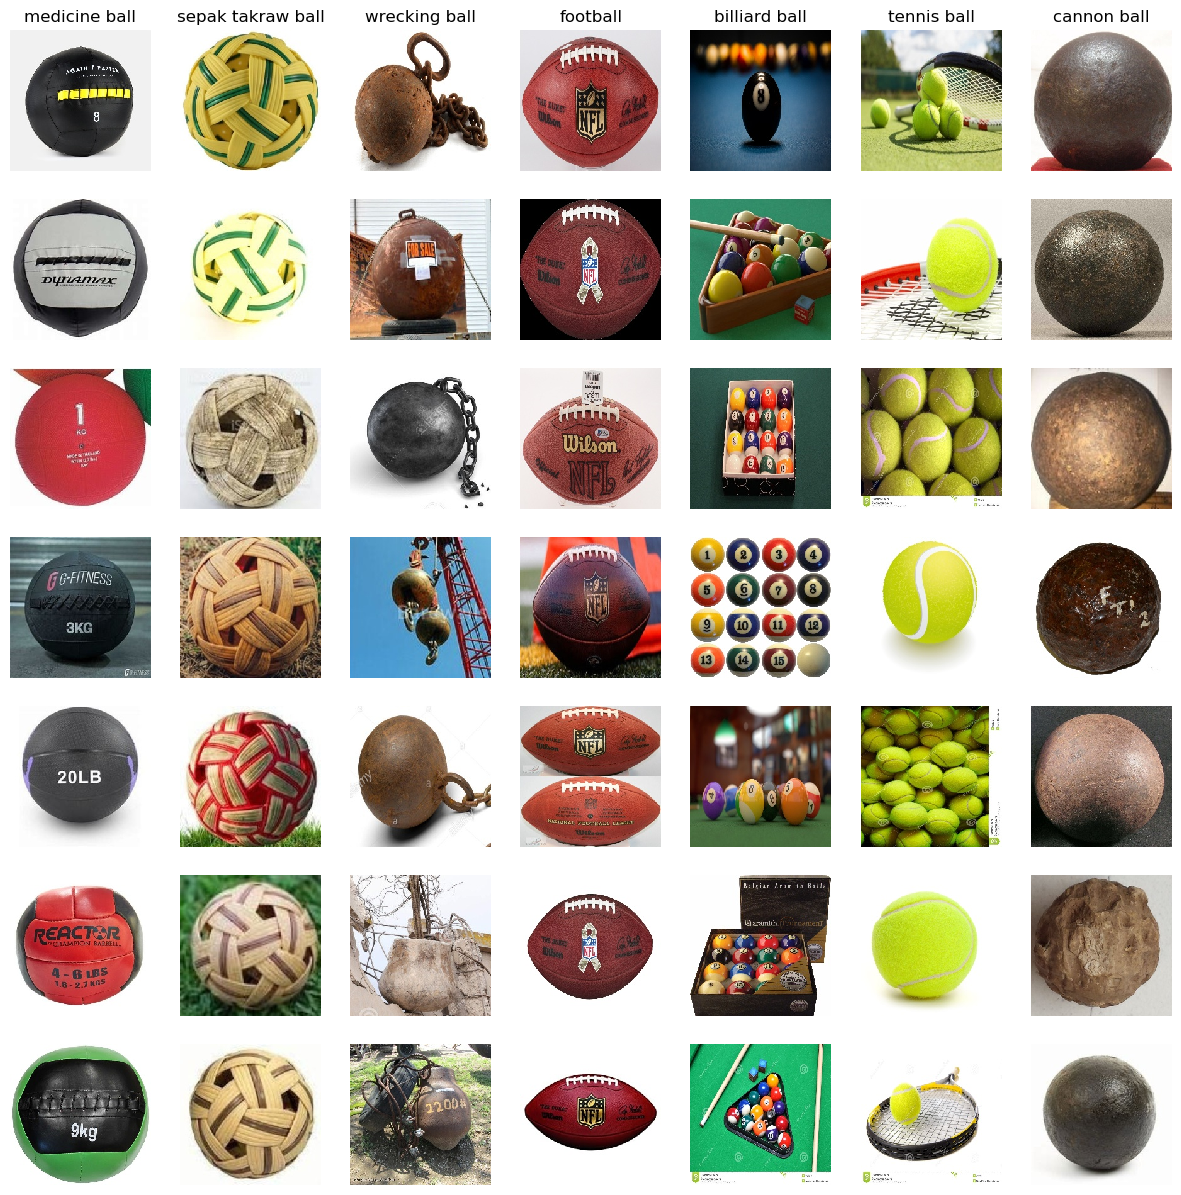

In [3]:
# Function to show images
def imshow(img, title):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Function to visualize dataset
def visualize_dataset(dataset, classes, samples_per_class=7, num_classes_to_display=7):
    selected_classes = random.sample(classes, num_classes_to_display)
    selected_class_indices = [classes.index(cls) for cls in selected_classes]

    num_classes = len(selected_classes)
    fig = plt.figure(figsize=(15, 15))

    for y, cls in enumerate(selected_classes):
        class_indices = [i for i, (img, label) in enumerate(dataset) if label == selected_class_indices[y]]
        selected_indices = random.sample(class_indices, samples_per_class)

        for i, idx in enumerate(selected_indices):
            img, label = dataset[idx]
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            imshow(img, cls if i == 0 else '')

    plt.show()

# Get class names
classes = train_dataset.classes

# Visualize the training dataset
visualize_dataset(train_dataset, classes, samples_per_class=7, num_classes_to_display=7)

# Defining the Model
Define and compile a CNN model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class BallClassifierCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BallClassifierCNN, self).__init__()

        self.layer1 = self._make_layer(3, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, 30)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.global_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        return F.log_softmax(out, dim=1)


In [5]:
model = BallClassifierCNN().to(device)
loss_fn = nn.CrossEntropyLoss()

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"New Best. Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

# Training

In [7]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
best_loss = 100
best_val_acc = 0
size = len(train_loader.dataset)
epoch = 0
losses = []
while epoch<1000:
    model.train()
    running_loss = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    #learning_rate -= learning_rate/10 #adjust learning rate
    cal_loss = running_loss/len(train_loader)
    print(f'Epoch [{epoch+1}], Loss: {cal_loss}')
    losses.append(cal_loss)
    if best_loss > cal_loss:
        best_loss = cal_loss
        acc = test(val_loader, model, loss_fn)
        if acc > best_val_acc:
            best_val_acc = acc
            if acc > 0.8: 
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': cal_loss
                }, f"./balls_image_classification/model/residual_model_val_acc_{acc:.4f}.pt")
    epoch += 1

Epoch [1], Loss: 2.9144779918468102
New Best. Accuracy: 22.0%, Avg loss: 2.739236 

Epoch [2], Loss: 2.531768174298042
New Best. Accuracy: 34.0%, Avg loss: 2.363857 

Epoch [3], Loss: 2.281551272468229
New Best. Accuracy: 39.3%, Avg loss: 2.260673 

Epoch [4], Loss: 2.151011694849065
New Best. Accuracy: 48.0%, Avg loss: 1.963931 

Epoch [5], Loss: 1.9932404840941977
New Best. Accuracy: 40.7%, Avg loss: 2.212950 

Epoch [6], Loss: 1.8989098040403518
New Best. Accuracy: 45.3%, Avg loss: 1.812683 

Epoch [7], Loss: 1.8029809430637191
New Best. Accuracy: 54.7%, Avg loss: 1.576989 

Epoch [8], Loss: 1.7083414972355935
New Best. Accuracy: 43.3%, Avg loss: 2.426459 

Epoch [9], Loss: 1.6024079670948266
New Best. Accuracy: 49.3%, Avg loss: 2.011462 

Epoch [10], Loss: 1.500077032409938
New Best. Accuracy: 55.3%, Avg loss: 1.553686 

Epoch [11], Loss: 1.415494378689116
New Best. Accuracy: 56.7%, Avg loss: 1.436617 

Epoch [12], Loss: 1.4113009255544273
New Best. Accuracy: 63.3%, Avg loss: 1.423

# Testing
Test the model and show test results

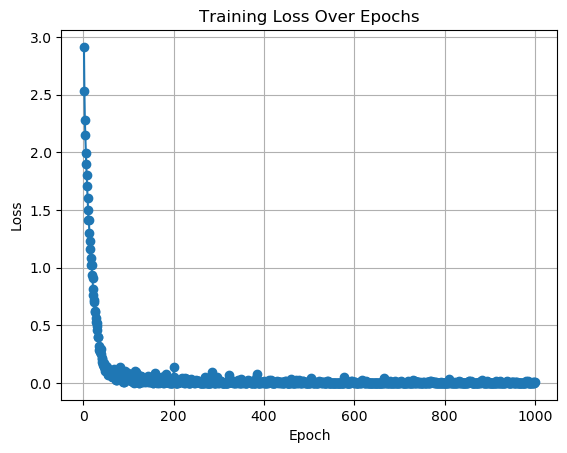

In [14]:
plt.plot(range(1, epoch+1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [19]:
curr_best_model = BallClassifierCNN().to(device)
checkpoint = torch.load("./balls_image_classification/model/residual_model_val_acc_0.9067.pt")
curr_best_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
#loss_fn = nn.CrossEntropyLoss()
#test(test_loader, curr_best_model, loss_fn)
test(test_loader, model, loss_fn)

New Best. Accuracy: 83.3%, Avg loss: 1.089288 



0.8333333333333334

In [18]:
#loss_fn = nn.CrossEntropyLoss()
#test(test_loader, curr_best_model, loss_fn)
test(test_loader, curr_best_model, loss_fn)

New Best. Accuracy: 86.0%, Avg loss: 0.748039 



0.86

In [20]:
test(test_loader, curr_best_model, loss_fn)

New Best. Accuracy: 85.3%, Avg loss: 0.684335 



0.8533333333333334